# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2024-10-24"

n_particles = 4
video_name = "23_05_23_3_1080"
save_tracking = True
x_bounds = [40, 1020]
y_bounds = [160, 1740]
x_zoom = [760, 1000]
y_zoom = [1500, 1720]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 90650
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,coords_x,coords_y,orientation,area,area_convex,area_filled,axis_major,axis_minor,eccentricity,euler_number,id_count
0,0,0,131.361102,277.047904,129.820192,282.752376,NaN,131.361102,277.047904,NaN,131.361102,277.047904,"[144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...",-0.284792,9039.0,12978.0,9050.0,196.579324,71.364684,0.931776,-38,4
4,0,1,131.236932,278.569644,129.443543,285.456741,NaN,131.236932,278.569644,NaN,131.236932,278.569644,"[149.0, 144.0, 145.0, 146.0, 147.0, 148.0, 150...","[191.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...",-0.282948,9125.0,13383.0,9130.0,200.439365,71.376005,0.934449,-28,4
8,0,2,130.852105,279.393880,128.730319,286.725444,NaN,130.852105,279.393880,NaN,130.852105,279.393880,"[144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...",-0.291144,9216.0,13395.0,9224.0,202.947784,71.576119,0.935743,-38,4
12,0,3,130.838622,279.375571,128.709282,286.707372,NaN,130.838622,279.375571,NaN,130.838622,279.375571,"[144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150...","[192.0, 192.0, 192.0, 192.0, 192.0, 192.0, 192...",-0.291134,9202.0,13387.0,9210.0,202.794547,71.501212,0.935782,-35,4


In [6]:
# Manual Setup for time = 0
# tracking_0 = df_tracked_frames_final[df_tracked_frames_final["time"] == 0]

# if tracking_0.shape[0] != n_particles:
#     tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
#     tracking_for_clustering = pd.concat([
#         tracking_0,
#         df_tracked_frames_final[df_tracked_frames_final["time"] != 0]
#     ])

## Velocities distribution in each frame

In [7]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


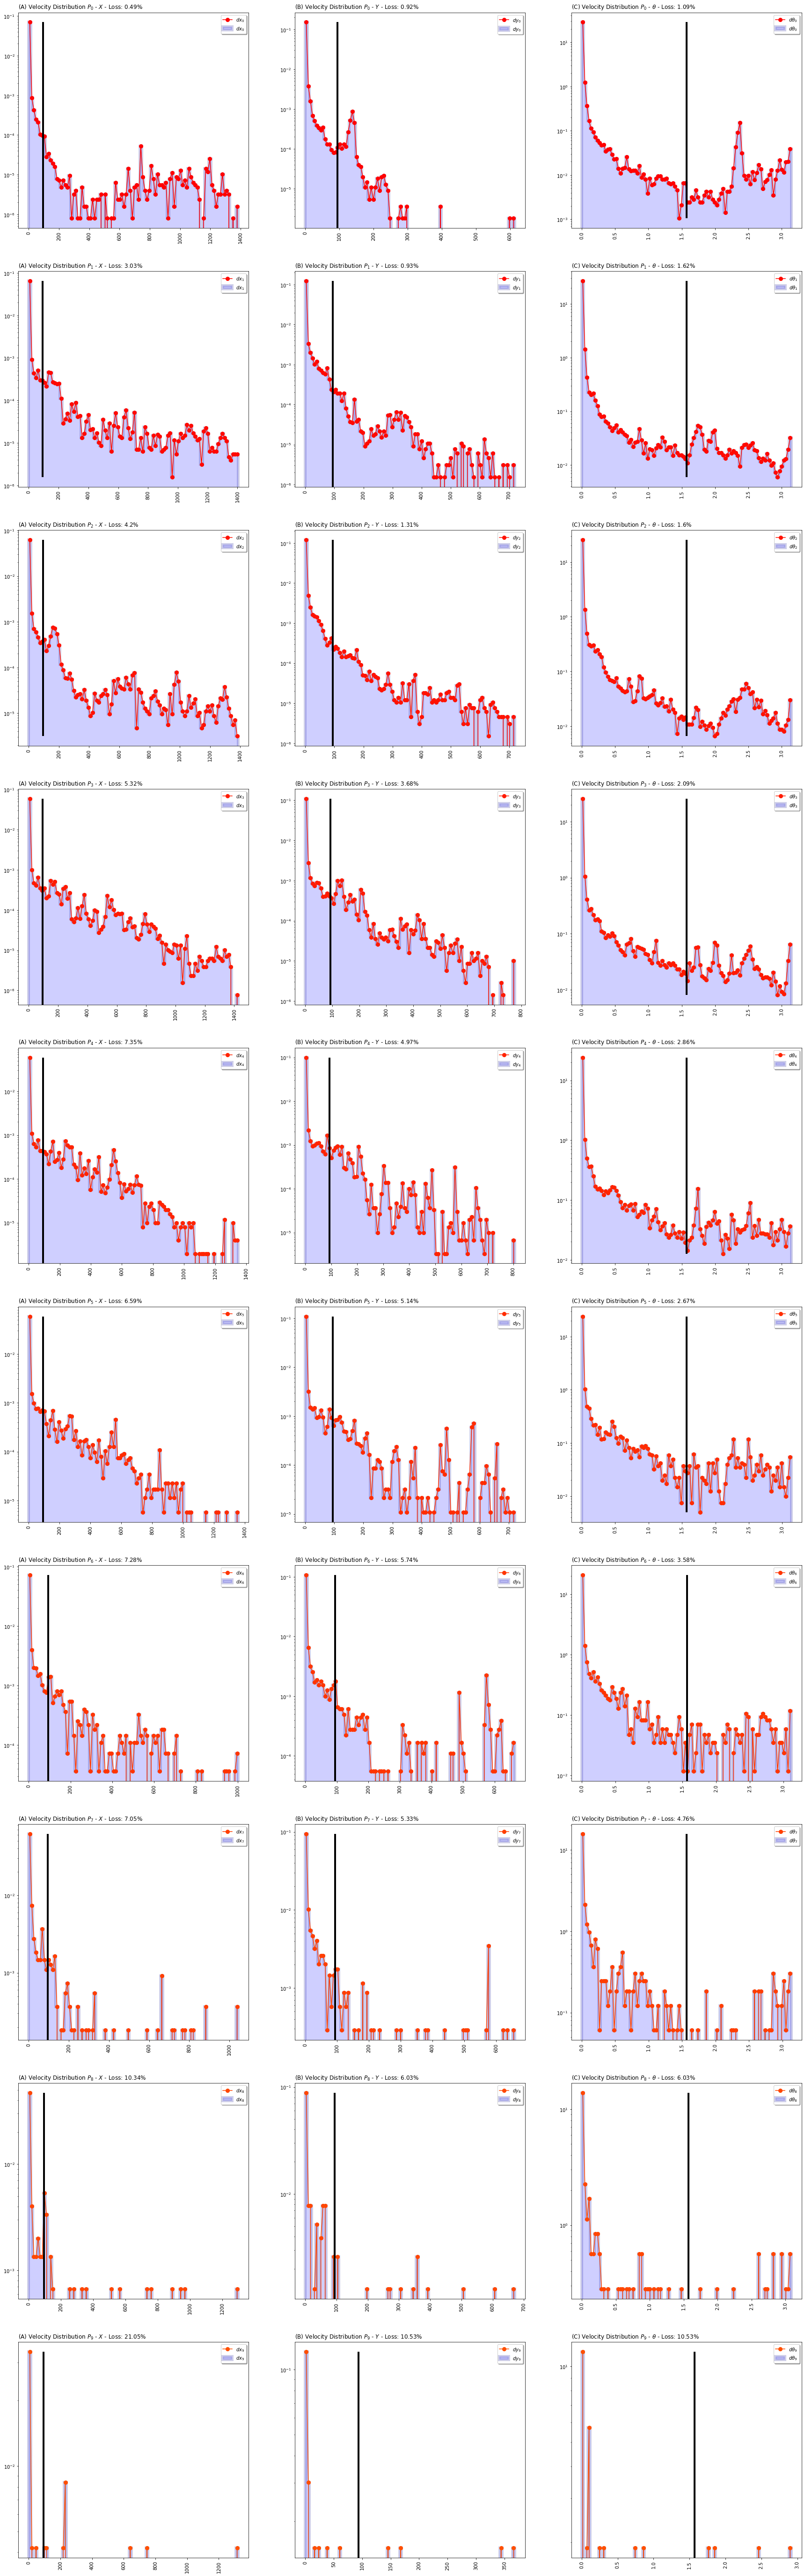

In [8]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [9]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,8
1,3,840
2,4,210832
3,5,123655
4,6,61158
5,7,15463
6,8,3272
7,9,873
8,10,190


## Clustering frames

In [10]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.925) # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 94.61044311645506 
	- Angle: 90.76415689932814 



In [19]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [12]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.000961
1,2,False,True,False,0.000240
2,2,False,True,True,0.000240
3,2,True,True,False,0.000480
4,3,False,False,False,0.167671
...,...,...,...,...,...
60,10,False,False,True,0.002642
61,10,False,True,False,0.000240
62,10,True,False,False,0.007206
63,10,True,False,True,0.002402


In [13]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.925) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.61044311645506 
	- Angle: 90.76415689932814 



In [14]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 1.180341941483654%
Final loss data X-axis: 1.2031783939645735%
Final loss data Y-axis: 0.36978544740187197%
Final loss data Angle : 1.0334182592570176%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.000550
1,3,False,False,False,0.000550
2,3,False,True,False,0.000275
3,3,False,True,True,0.000275
4,3,True,True,True,0.003852
5,4,False,False,False,0.066033
6,4,False,False,True,0.200300
7,4,False,True,False,0.141971
8,4,False,True,True,0.783868
9,4,True,False,False,0.015133


In [15]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 94.61044311645506 
	- Angle: 90.76415689932814 



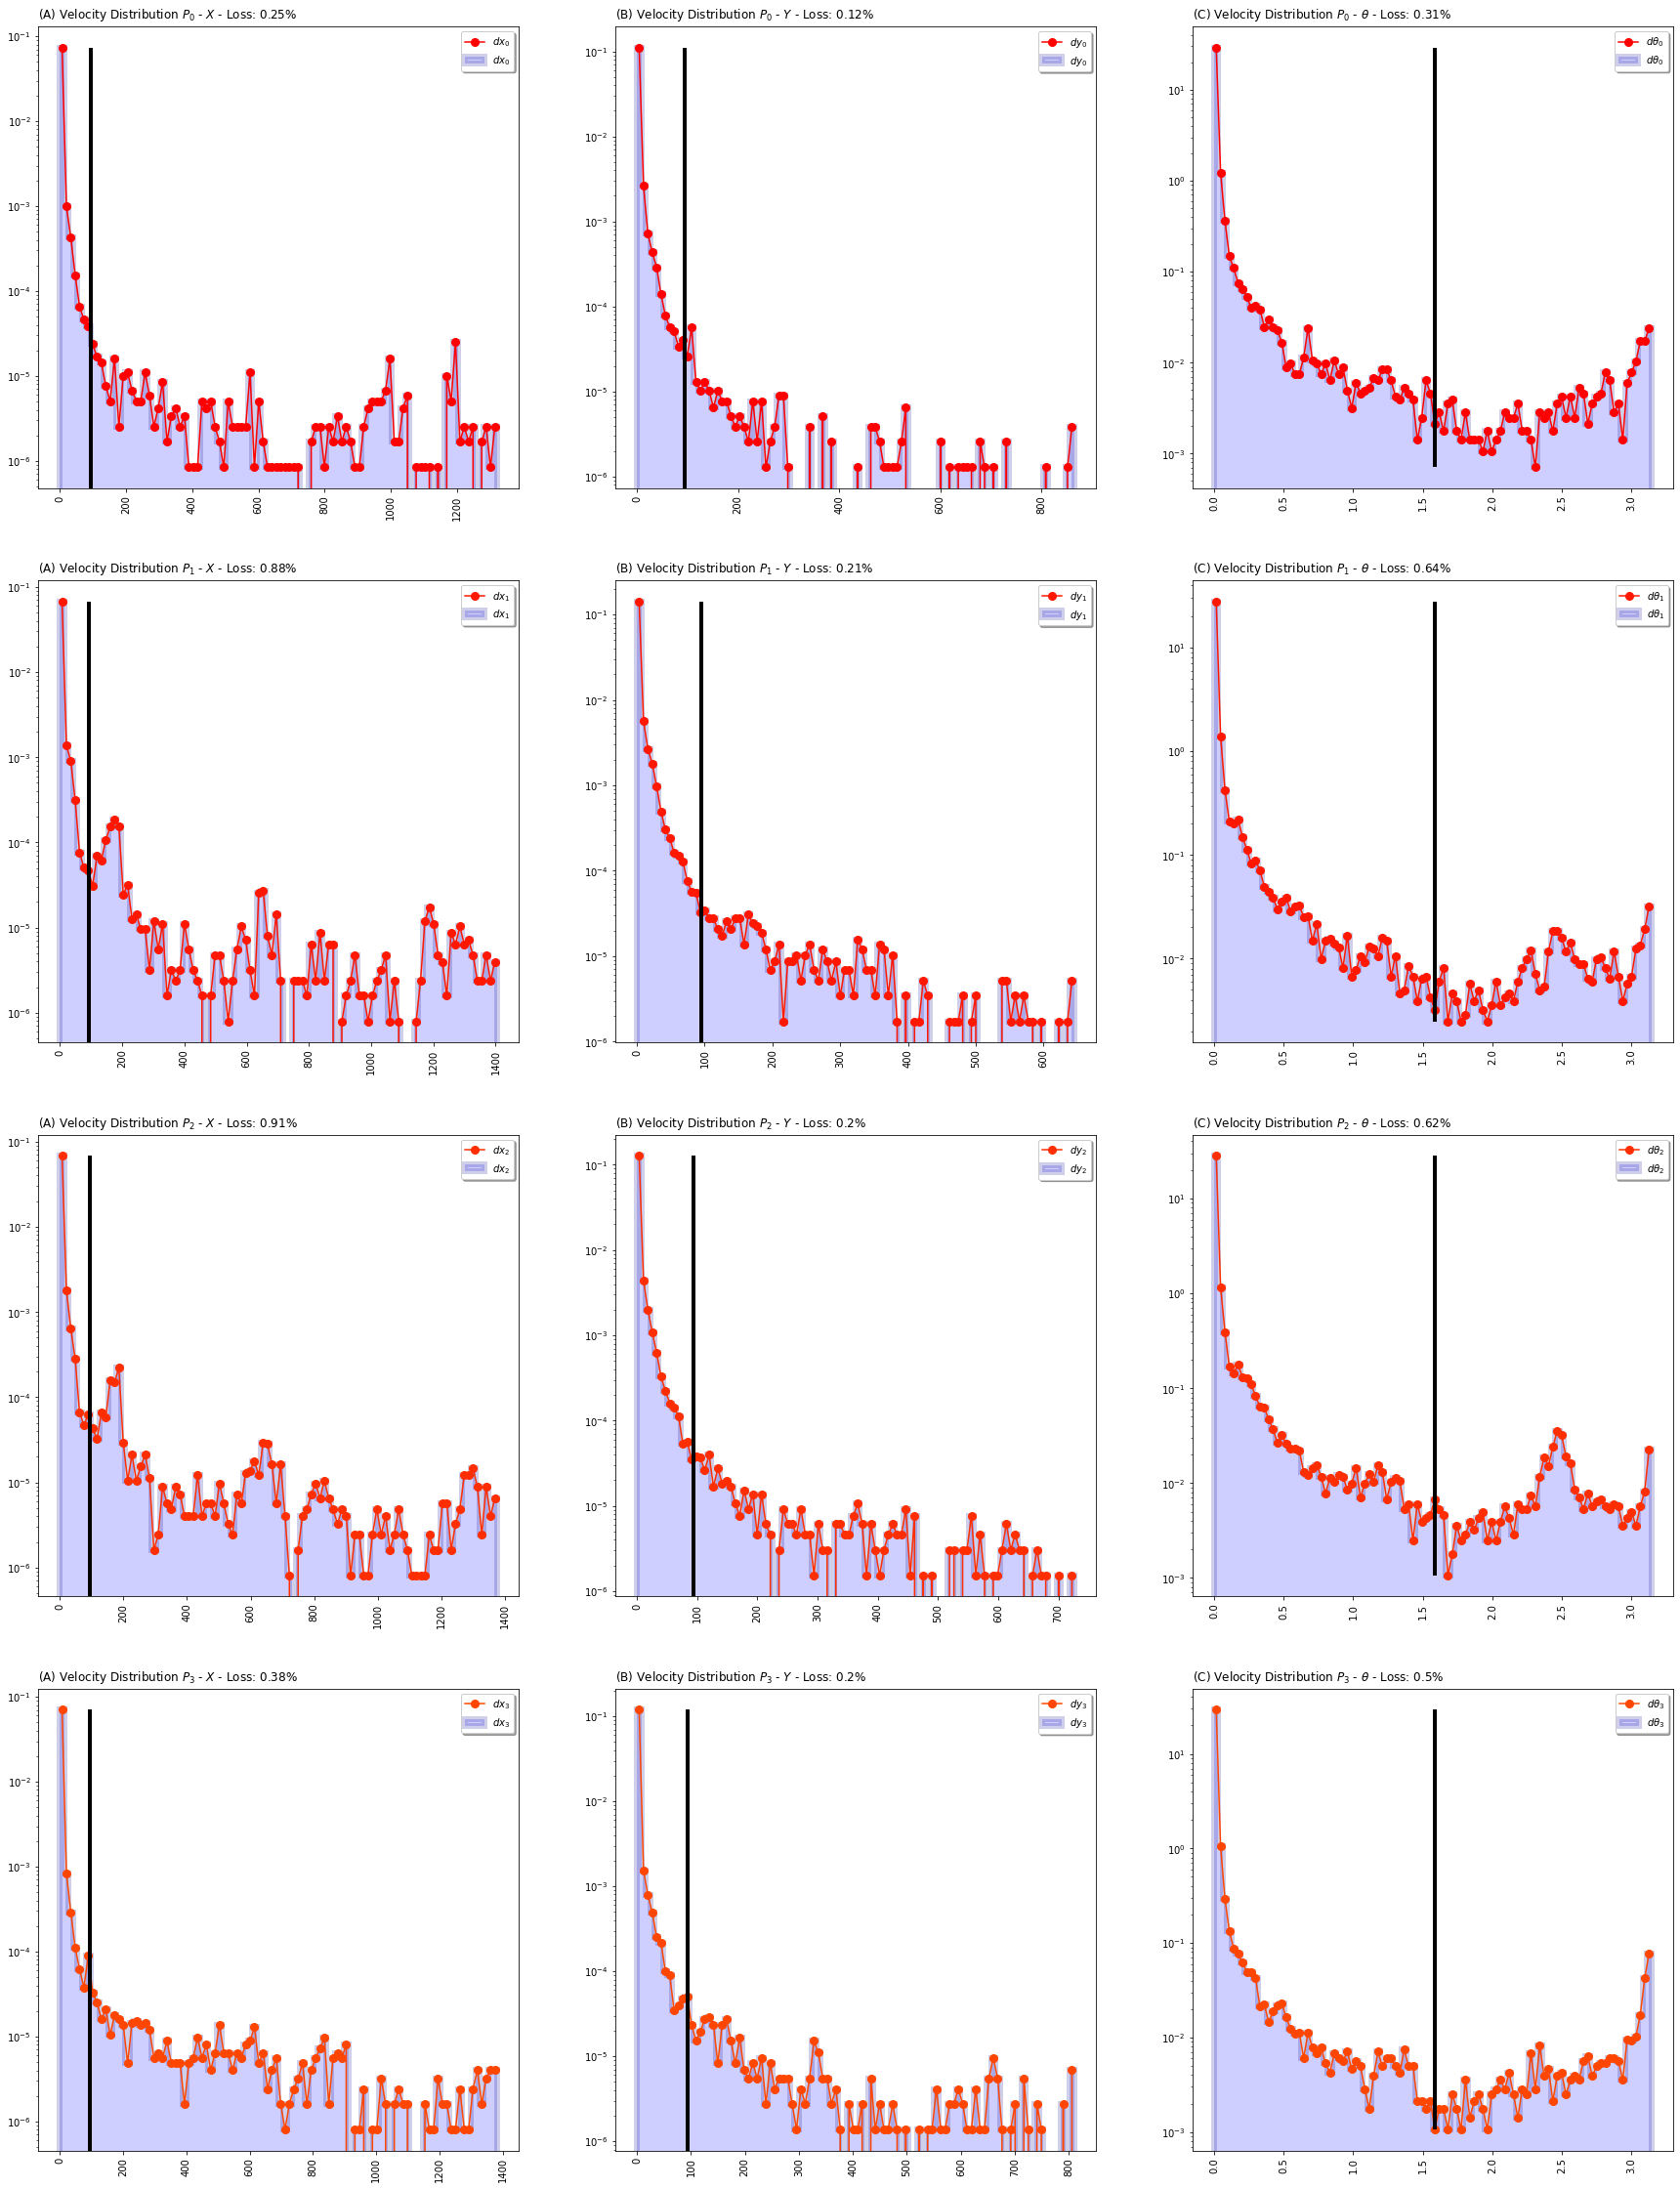

In [16]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.925) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [17]:
df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

## Visualize final data

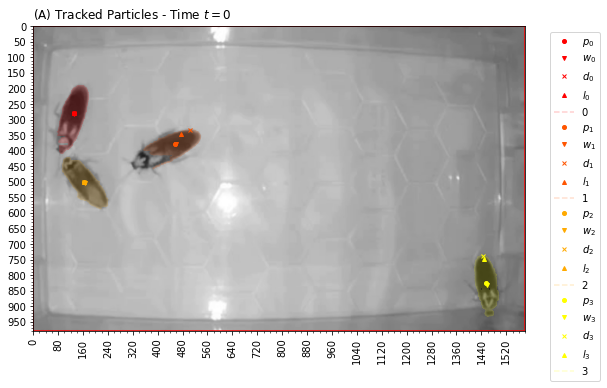

In [18]:
# Original frame
# save_tracking = True
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # [40, 1020]
y_bounds = y_bounds  # [160, 1740]
x_zoom = None  # x_zoom  # [760, 1000]
y_zoom = None  # y_zoom  # [1500, 1720]
fancy_legend = True
x_legend = 1.050
y_legend = 0.981
interval = 500
fps = 25
output_name = "clustered_" + video_name

if save_tracking:
# Clustered
    plt_tp.plot_tracking_animation(
        reader=reader,
        df_tracked_frames=df_filter_clustered,
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        x_bounds=x_bounds,
        y_bounds=y_bounds,
        x_zoom=x_zoom,
        y_zoom=y_zoom,
        fancy_legend=fancy_legend,
        x_legend=x_legend,
        y_legend=y_legend,
        interval=interval,
        fps=fps,
        output_path=output_path,
        output_name=output_name
    )